# Credit Card Default Data

### Description:
A simulated data set containing information on ten thousand customers. The aim here is to predict which customers will default on their credit card debt.

### Usage
Default

### Format
A data frame with 10000 observations on the following 4 variables.

*default:*
A factor with levels No and Yes indicating whether the customer defaulted on their debt

*student:*
A factor with levels No and Yes indicating whether the customer is a student

*balance:*
The average balance that the customer has remaining on their credit card after making their monthly payment

*income:*
Income of customer

### Source:
Simulated data

### References
James, G., Witten, D., Hastie, T., and Tibshirani, R. (2013) An Introduction to Statistical Learning with applications in R, www.StatLearning.com, Springer-Verlag, New York

In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns # for making plots with seaborn
color = sns.color_palette()
import sklearn.metrics as metrics

import warnings
warnings.filterwarnings("ignore")

#!pip install imblearn

Let us now go ahead and read the dataset and check the first five rows of the dataset.

#### Importing the dataset

In [2]:
Default = pd.read_csv('Default.csv')

#Glimpse of Data
Default.head()

,default,student,balance,income
0,No,No,729.53,44361.63
1,No,Yes,817.18,12106.13
2,No,No,1073.55,31767.14
3,No,No,529.25,35704.49
4,No,No,785.66,38463.50


#### First, let us check the number of rows (observations) and the number of columns (variables).

In [3]:
print('The number of rows (observations) is',Default.shape[0],'\n''The number of columns (variables) is',Default.shape[1])

The number of rows (observations) is 10000 
The number of columns (variables) is 4


#### Now, let us check the basic measures of descriptive statistics for the continuous variables.

In [4]:
Default.describe()

,balance,income
count,10000.000000,10000.000000
mean,835.374877,33516.981852
std,483.714957,13336.639582
min,0.000000,771.970000
25%,481.732500,21340.460000
50%,823.635000,34552.645000
75%,1166.305000,43807.730000
max,2654.320000,73554.230000


#### Univariate Analysis: Balance & Income variables

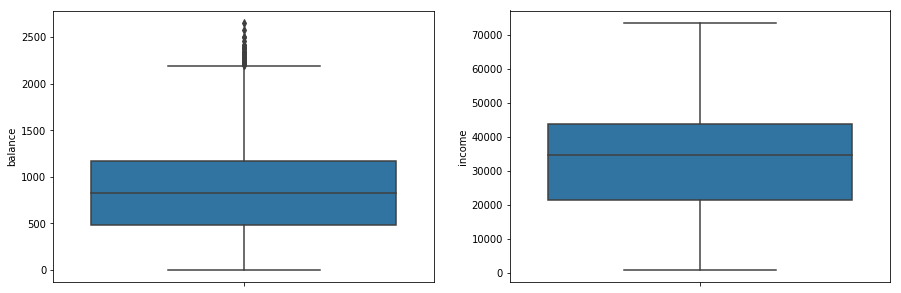

In [5]:
plt.figure(figsize = (15, 5))
plt.subplot(1,2,1)
sns.boxplot(y = Default['balance'])

plt.subplot(1,2,2)
sns.boxplot(y = Default['income'])
plt.show()

#### Univariate Analysis: Student & Default variables

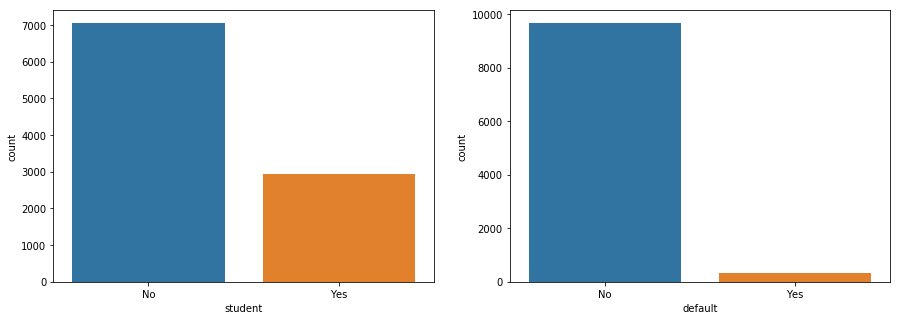

In [6]:
plt.figure(figsize = (15, 5))
plt.subplot(1,2,1)
sns.countplot(Default['student'])

plt.subplot(1,2,2)
sns.countplot(Default['default'])
plt.show()

#### Now, let us check the basic measures of descriptive statistics for the categorical variables.

In [7]:
Default["student"].value_counts()

No     7056
Yes    2944
Name: student, dtype: int64

In [8]:
Default["default"].value_counts()

No     9667
Yes     333
Name: default, dtype: int64

#### Checking proportion of default

In [9]:
Default["default"].value_counts(normalize = True)

No     0.9667
Yes    0.0333
Name: default, dtype: float64

Data seems highly imbalanced

#### Bivariate Analysis: Default Vs. other variables

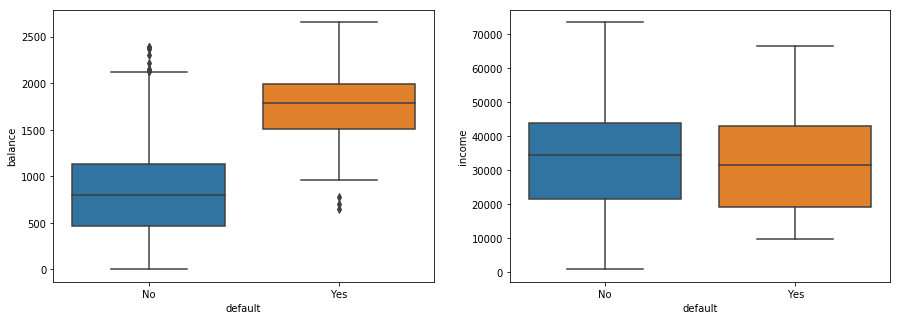

In [10]:
plt.figure(figsize = (15, 5))
plt.subplot(1,2,1)
sns.boxplot(Default['default'], Default['balance'])

plt.subplot(1,2,2)
sns.boxplot(Default['default'], Default['income'])
plt.show()

##### Inference: 
Defaulters seem to have higher outstanding balance compared non-defaulters.
Defaulters' income seems lower compared to non-defaulters.

In [11]:
pd.crosstab(Default['student'], Default['default'], normalize = 'index').round(2)

default,No,Yes
student,,
No,0.97,0.03
Yes,0.96,0.04


#### Check for correlation between independent variables

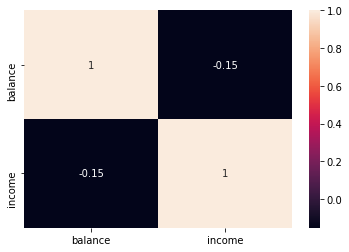

In [12]:
sns.heatmap(Default[['balance', 'income']].corr(), annot = True)
plt.show()

#### Check for missing values

In [13]:
Default.isnull().sum()

default    0
student    0
balance    0
income     0
dtype: int64

There are no missing values in the dataset.

#### Treating outliers present in the 'balance' variable

In [14]:
Q1, Q3 = Default['balance'].quantile([.25, .75])
IQR = Q3 - Q1
LL = Q1 - 1.5*(IQR)
UL = Q3 + 1.5*(IQR)

In [15]:
df = Default[Default['balance'] > UL]

In [16]:
df['default'].count()

31

In [17]:
df['default'].value_counts(normalize = True)

Yes    0.83871
No     0.16129
Name: default, dtype: float64

Note: We have 31 outliers in total, of which 84%(approx 26 in number) are with a default status 1. As such we have only 333 default instances in our data therefore dropping these 26 i.e. 8% will not be a good option. 

In [18]:
Default['balance'] = np.where(Default['balance'] > UL, UL, Default['balance'] )

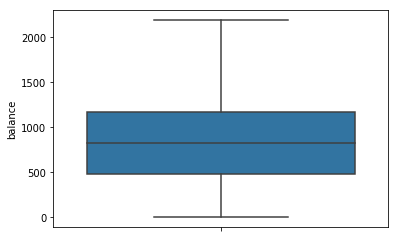

In [19]:
sns.boxplot(y = Default['balance'])
plt.show()

Outliers have been replaced

# Start of Credit Risk Modelling PD 

#### Transforming categorical variables into 1 & 0 using pandas get_dummies

In [20]:
#from sklearn import LabelEncoder
Default = pd.get_dummies(Default, drop_first = True)

#### Getting Top 5 rows

In [21]:
Default.head()

,balance,income,default_Yes,student_Yes
0,729.53,44361.63,0,0
1,817.18,12106.13,0,1
2,1073.55,31767.14,0,0
3,529.25,35704.49,0,0
4,785.66,38463.50,0,0


Relabeling the columns as per original names

In [22]:
Default.columns = ['balance', 'income', 'default', 'student']

In [23]:
Default.head()

,balance,income,default,student
0,729.53,44361.63,0,0
1,817.18,12106.13,0,1
2,1073.55,31767.14,0,0
3,529.25,35704.49,0,0
4,785.66,38463.50,0,0


#### Partitioning the data into train and test

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
X = Default.drop('default', axis = 1)
y = Default['default']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 21, stratify = y)

In [27]:
print(X_train.shape)
print(X_test.shape)

(7000, 3)
(3000, 3)


##### Why stratify = y?
Please note, because this data is highly imbalanced and could possibly result into different proportions in the y variable between train and test set.

In [28]:
print(y_train.value_counts(normalize = True).round(2))
print(' ')
print(y_test.value_counts(normalize = True).round(2))

0    0.97
1    0.03
Name: default, dtype: float64
 
0    0.97
1    0.03
Name: default, dtype: float64


#### Treating target imbalance using SMOTE

In [ ]:
#!pip install imblearn

In [29]:
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state=33, sampling_strategy = 0.75)
X_res, y_res = sm.fit_sample(X_train, y_train)

Using TensorFlow backend.


In [30]:
Default_smote = pd.concat([X_res, y_res], axis = 1)

In [31]:
Default.groupby('default').mean()

,balance,income,student
default,,,
0,803.870400,33566.166610,0.291404
1,1736.593536,32089.146847,0.381381


In [32]:
Default_smote.groupby('default').mean()

,balance,income,student
default,,,
0,807.913022,33555.565605,0.288902
1,1748.067687,31074.712267,0.337537


# Model Building using Logistic Regression for 'Probability at default'

## The equation of the Logistic Regression by which we predict the corresponding probabilities and then go on predict a discrete target variable is
# y = $\frac{1}{1 + {e^{-z}}}$

### Note: z  = $\beta_0$ +${\sum_{i=1}^{n}(\beta_i  X_1)}$

#### Now, Importing statsmodels modules

In [33]:
import statsmodels.formula.api as SM

#### Creating logistic regression equation & storing it in f_1

model = SM.logit(formula=’Dependent Variable ~ Σ𝐼𝑛𝑑𝑒𝑝𝑒𝑛𝑑𝑒𝑛𝑡 𝑉𝑎𝑟𝑖𝑎𝑏𝑙𝑒𝑠 (𝑘)’
               data = ‘Data Frame containing the required values’).fit()

In [34]:
train = pd.concat([X_train, y_train], axis = 1)
train_smote = pd.concat([X_res, y_res], axis = 1)
test = pd.concat([X_test, y_test], axis = 1)

In [35]:
f_1 = 'default ~ student + balance + income'

#### Fitting the logistic regression model on imbalanced data

In [36]:
model_1 = SM.logit(formula = f_1, data= train).fit()

Optimization terminated successfully.
         Current function value: 0.078006
         Iterations 10


#### Checking the parameters

In [37]:
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                default   No. Observations:                 7000
Model:                          Logit   Df Residuals:                     6996
Method:                           MLE   Df Model:                            3
Date:                Mon, 28 Dec 2020   Pseudo R-squ.:                  0.4657
Time:                        17:37:17   Log-Likelihood:                -546.04
converged:                       True   LL-Null:                       -1021.9
Covariance Type:            nonrobust   LLR p-value:                5.419e-206
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -10.4580      0.578    -18.080      0.000     -11.592      -9.324
student       -1.0130      0.282     -3.592      0.000      -1.566      -0.460
balance        0.0059      0.000     20.744      0.000       0.005       0.006
income      -1.53e-05   9.98e-06     -1.534      0.125   -3.49e-05    4.25e-06
==============================================================================

Possibly complete quasi-separation: A fraction 0.16 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

#### Validating the model on train set 

In [38]:
y_pred_train = np.where(model_1.predict(train) > 0.5, 1, 0)

In [39]:
from sklearn.metrics import confusion_matrix, classification_report

In [40]:
print(confusion_matrix(y_train, y_pred_train))

[[6737   30]
 [ 158   75]]


In [41]:
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      6767
           1       0.71      0.32      0.44       233

    accuracy                           0.97      7000
   macro avg       0.85      0.66      0.72      7000
weighted avg       0.97      0.97      0.97      7000



#### Validating the model on test set 

In [42]:
y_pred_test = np.where(model_1.predict(test) > 0.5, 1, 0)

In [43]:
print(confusion_matrix(y_test, y_pred_test))

[[2888   12]
 [  66   34]]


In [44]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2900
           1       0.74      0.34      0.47       100

    accuracy                           0.97      3000
   macro avg       0.86      0.67      0.73      3000
weighted avg       0.97      0.97      0.97      3000



Model is not overfitting but the recall is really poor.

#### Fitting the logistic regression model on balanced data

In [45]:
model_2 = SM.logit(formula = f_1, data= train_smote).fit()

Optimization terminated successfully.
         Current function value: 0.236659
         Iterations 8


In [46]:
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                default   No. Observations:                11842
Model:                          Logit   Df Residuals:                    11838
Method:                           MLE   Df Model:                            3
Date:                Mon, 28 Dec 2020   Pseudo R-squ.:                  0.6535
Time:                        17:42:41   Log-Likelihood:                -2802.5
converged:                       True   LL-Null:                       -8087.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -8.6320      0.240    -35.967      0.000      -9.102      -8.162
student       -1.7174      0.120    -14.283      0.000      -1.953      -1.482
balance        0.0072      0.000     51.698      0.000       0.007       0.007
income      -2.84e-05   4.09e-06     -6.935      0.000   -3.64e-05   -2.04e-05
==============================================================================
"""

#### Validating on resampled train set

In [47]:
y_pred_train_smote = np.where(model_2.predict(train_smote) > 0.5, 1, 0)

In [48]:
print(confusion_matrix(y_res, y_pred_train_smote))

[[6111  656]
 [ 500 4575]]


In [49]:
print(classification_report(y_res, y_pred_train_smote))

              precision    recall  f1-score   support

           0       0.92      0.90      0.91      6767
           1       0.87      0.90      0.89      5075

    accuracy                           0.90     11842
   macro avg       0.90      0.90      0.90     11842
weighted avg       0.90      0.90      0.90     11842



#### Validating on test set

In [50]:
y_pred_test_smote = np.where(model_2.predict(test) > 0.5, 1, 0)

In [51]:
print(confusion_matrix(y_test, y_pred_test_smote))

[[2634  266]
 [  18   82]]


In [52]:
print(classification_report(y_test, y_pred_test_smote))

              precision    recall  f1-score   support

           0       0.99      0.91      0.95      2900
           1       0.24      0.82      0.37       100

    accuracy                           0.91      3000
   macro avg       0.61      0.86      0.66      3000
weighted avg       0.97      0.91      0.93      3000



## Conclusion
We can see that we get better recall value after balancing the data but precision is now a problem. This trade-off between recall and precision can be approached by adjusting the threshold. Note that at present we are using a threshold of 0.5.

Also, learners might want to try other classification models(particularly the ones that are not sensitive to outliers) and perform a comparison between different models.  

## END